# 第5章

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
%matplotlib inline
plt.style.use("ggplot")

### ab_test_impデータにab_test_goalデータをくっつける

In [2]:
# データの読みこみ
ab_test_imp = pd.read_csv("../Data/section5-ab_test_imp.csv")
ab_test_imp.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id
0,2013-10-01,game-01,sales_test,B,36703,25622
1,2013-10-01,game-01,sales_test,A,44339,25623
2,2013-10-01,game-01,sales_test,B,32087,25624
3,2013-10-01,game-01,sales_test,B,10160,25625
4,2013-10-01,game-01,sales_test,B,46113,25626


In [3]:
ab_test_goal = pd.read_csv("../Data/section5-ab_test_goal.csv")
ab_test_goal.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id
0,2013-10-01,game-01,sales_test,B,15021,25638
1,2013-10-01,game-01,sales_test,B,351,25704
2,2013-10-01,game-01,sales_test,B,8276,25739
3,2013-10-01,game-01,sales_test,B,1230,25742
4,2013-10-01,game-01,sales_test,B,17471,25743


In [4]:
# ab_test_impにab_test_goalをくっつける
ab_test_imp = pd.merge(ab_test_imp, ab_test_goal, on = "transaction_id", how = "left", suffixes = ["", "_g"])
ab_test_imp.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id,log_date_g,app_name_g,test_name_g,test_case_g,user_id_g
0,2013-10-01,game-01,sales_test,B,36703,25622,NaN,NaN,NaN,NaN,NaN
1,2013-10-01,game-01,sales_test,A,44339,25623,NaN,NaN,NaN,NaN,NaN
2,2013-10-01,game-01,sales_test,B,32087,25624,NaN,NaN,NaN,NaN,NaN
3,2013-10-01,game-01,sales_test,B,10160,25625,NaN,NaN,NaN,NaN,NaN
4,2013-10-01,game-01,sales_test,B,46113,25626,NaN,NaN,NaN,NaN,NaN


### クリックしたかどうかのフラグを作る

In [5]:
# クリックフラグの追加
ab_test_imp["is_goal"] = np.where(ab_test_imp["user_id_g"].isnull(), 0, 1)
ab_test_imp.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id,log_date_g,app_name_g,test_name_g,test_case_g,user_id_g,is_goal
0,2013-10-01,game-01,sales_test,B,36703,25622,NaN,NaN,NaN,NaN,NaN,0
1,2013-10-01,game-01,sales_test,A,44339,25623,NaN,NaN,NaN,NaN,NaN,0
2,2013-10-01,game-01,sales_test,B,32087,25624,NaN,NaN,NaN,NaN,NaN,0
3,2013-10-01,game-01,sales_test,B,10160,25625,NaN,NaN,NaN,NaN,NaN,0
4,2013-10-01,game-01,sales_test,B,46113,25626,NaN,NaN,NaN,NaN,NaN,0


### クリック率の集計

In [6]:
# クリック率の計算
cvr = ab_test_imp.groupby("test_case")["is_goal"].sum() / ab_test_imp.groupby("test_case")["user_id"].count() 
pd.DataFrame(cvr, columns = ["cvr"])

,cvr
test_case,
A,0.080256
B,0.115460


### カイ2乗検定の実行

In [7]:
# カイ2乗検定の実行
crosstab = pd.pivot_table(ab_test_imp, index = "test_case", columns = "is_goal", values = "user_id", aggfunc = len)
chi2, p, dof, _ = chi2_contingency(crosstab)
print("カイ2乗: %f" % chi2)
print("自由度: %d" % dof)
print("p値: %f" % p)

カイ2乗: 308.375053
自由度: 1
p値: 0.000000


### テストケースごとのクリック率の算出

In [8]:
# 日付ごとテストケースごとにクリック率を算出
ab_test_imp_summary = ab_test_imp.groupby(["log_date", "test_case"])["is_goal"].agg({"imp": "count", "cv": "sum"}).reset_index()
ab_test_imp_summary["cvr"] = ab_test_imp_summary["cv"]  / ab_test_imp_summary["imp"] 
ab_test_imp_summary.head()

,log_date,test_case,imp,cv,cvr
0,2013-10-01,A,1358,98,0.072165
1,2013-10-01,B,1391,176,0.126528
2,2013-10-02,A,1370,88,0.064234
3,2013-10-02,B,1333,212,0.159040
4,2013-10-03,A,1213,170,0.140148


In [9]:
# テストケースごとのクリック率を算出
tmp = ab_test_imp_summary.drop("cvr", axis = 1).groupby("test_case").sum()
tmp["cvr_avg"] = tmp["cv"] / tmp["imp"]
tmp = tmp[["cvr_avg"]].reset_index()
pd.merge(ab_test_imp_summary, tmp).head()

,log_date,test_case,imp,cv,cvr,cvr_avg
0,2013-10-01,A,1358,98,0.072165,0.080256
1,2013-10-02,A,1370,88,0.064234,0.080256
2,2013-10-03,A,1213,170,0.140148,0.080256
3,2013-10-04,A,1521,89,0.058514,0.080256
4,2013-10-05,A,1587,56,0.035287,0.080256


### テストケースごとのクリック率の時系列グラフ

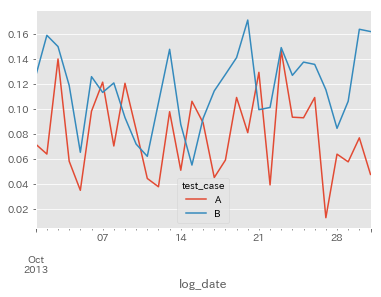

In [10]:
ab_test_imp_summary["log_date"] = pd.to_datetime(ab_test_imp_summary["log_date"])
ab_test_imp_summary[["log_date", "test_case", "cvr"]].groupby(["log_date", "test_case"])["cvr"].max().unstack().plot()